In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
%matplotlib widget

In [2]:
%matplotlib inline
from COB_model import get_COB_model
from COBresolve import COBresolve_image
import higra as hg
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [3]:
weigth_path='COB_PASCALContext_trainval.h5'
input_shape=(None,None,3)
model=get_COB_model(weigth_path,input_shape)
predicter=COBresolve_image(model)


/home/sgr/Загрузки/cob_tf/python/COBresolve.py:100: RuntimeWarning: invalid value encountered in true_divide
  O=(np.sum(ab*w1w2,axis=0)/np.sum((ab>0)*w1w2,axis=0)*((ind1*ind2==0)+(abs(ind1-ind2)==1))-1)*np.pi/numClusters


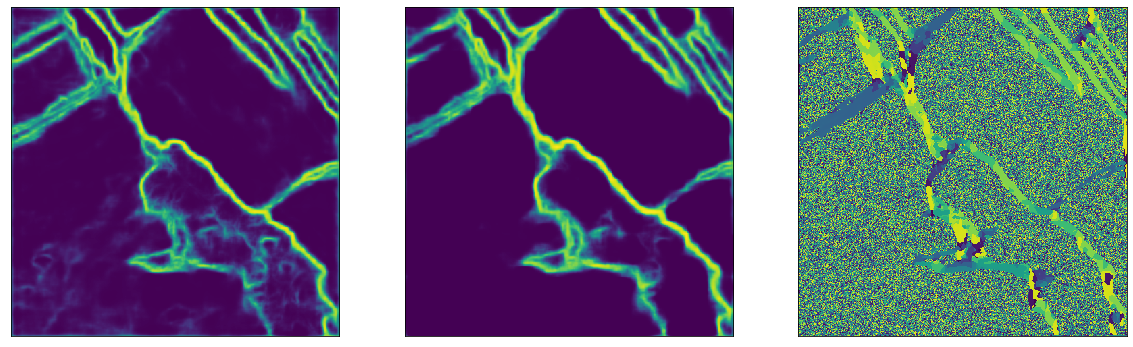

In [177]:
# image_name='10078660_15_cr.png'
# image_name='2010_005731.png'
image_name='2010_005731_.png'
# image_name='101087.jpg'
# image_name='2018.ppm'
base='../demo'
image_path = '{0}/{1}'.format(base,image_name)

image=np.asarray(Image.open(image_path))#.transpose(1,0,2)


output=predicter.resolve_imar(image)
# output=predicter.resolve_image(image_path)

plt.figure(figsize=(20,20))
for num, im in enumerate(output):
    plt.subplot(1,3,num+1)
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])

In [86]:
image.shape[:2]

(489, 487)

In [89]:
output[2].shape

(489, 487)

In [5]:
def get_contour(output):
    size = output[0].shape[:2]

    gradient_coarse = output[1]
    gradient_fine = output[0]
    gradient_orientation = output[2]

    graph = hg.get_4_adjacency_graph(size)
    edge_weights_fine = hg.weight_graph(graph, gradient_fine, hg.WeightFunction.mean)
    edge_weights_coarse = hg.weight_graph(graph, gradient_coarse, hg.WeightFunction.mean)

    # special handling for angles to wrap around the trigonometric cycle...
    edge_orientations_source = hg.weight_graph(graph, gradient_orientation, hg.WeightFunction.source) 
    edge_orientations_target = hg.weight_graph(graph, gradient_orientation, hg.WeightFunction.target) 
    edge_orientations = hg.mean_angle_mod_pi(edge_orientations_source, edge_orientations_target)

    combined_hierarchy, altitudes_combined = hg.multiscale_mean_pb_hierarchy(graph, edge_weights_fine, others_edge_weights=(edge_weights_coarse,), edge_orientations=edge_orientations)
    outlines=hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(combined_hierarchy, altitudes_combined))
    return outlines


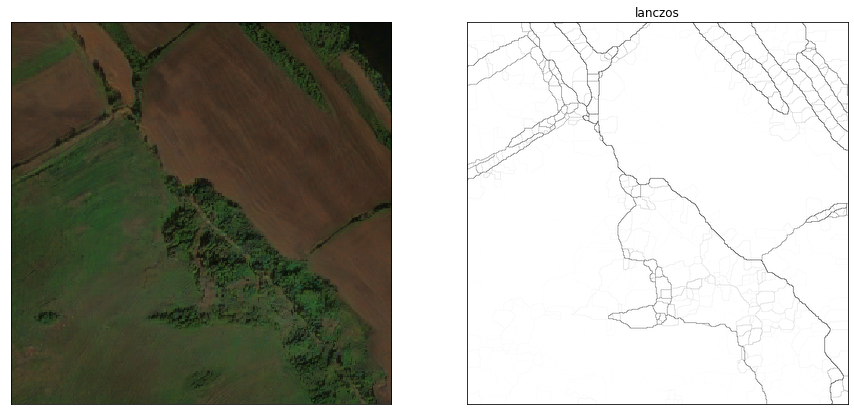

In [178]:
# get hierarchical contours
size = image.shape[:2]

gradient_coarse = output[1]
gradient_fine = output[0]
gradient_orientation = output[2]

graph = hg.get_4_adjacency_graph(size)
edge_weights_fine = hg.weight_graph(graph, gradient_fine, hg.WeightFunction.mean)
edge_weights_coarse = hg.weight_graph(graph, gradient_coarse, hg.WeightFunction.mean)

# special handling for angles to wrap around the trigonometric cycle...
edge_orientations_source = hg.weight_graph(graph, gradient_orientation, hg.WeightFunction.source) 
edge_orientations_target = hg.weight_graph(graph, gradient_orientation, hg.WeightFunction.target) 
edge_orientations = hg.mean_angle_mod_pi(edge_orientations_source, edge_orientations_target)

combined_hierarchy, altitudes_combined = hg.multiscale_mean_pb_hierarchy(graph, edge_weights_fine, others_edge_weights=(edge_weights_coarse,), edge_orientations=edge_orientations)
outlines=hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(combined_hierarchy, altitudes_combined))

intr=['none', 'nearest', 'bilinear', 'bicubic',
    'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser',
    'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc',
    'lanczos']

plt.figure(figsize=(15,20))
# plt.figure(figsize=(10,10))

intrr=16
for num, im in enumerate([image, outlines]):
    plt.subplot(1,2,num+1)
    if len(im.shape)==2:
        plt.imshow(1-im,cmap='gray', interpolation=intr[intrr])
        plt.title(intr[intrr])
    else:
        plt.imshow(im)
    plt.xticks([])
    plt.yticks([])



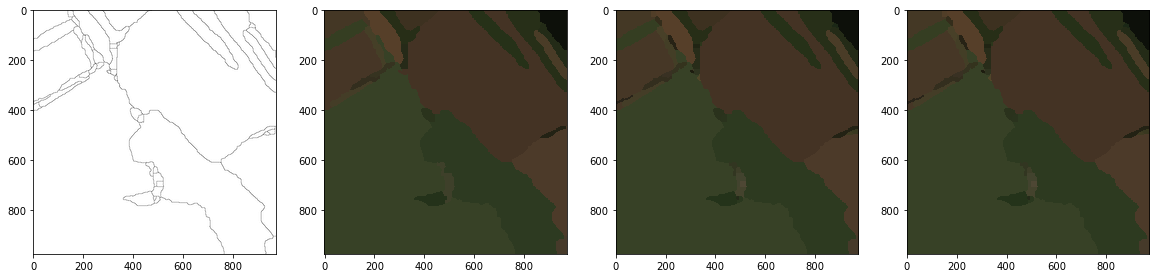

In [54]:

# dim=np.array(Image.fromarray(image).resize((641,961),Image.NEAREST))/255
dim=np.array(Image.fromarray(image).resize((973,977),Image.NEAREST))/255

outlines0=1/(1+np.exp(-outlines))
outlines0[outlines0<0.6]=0

gradient = outlines0

# Edge weighted 4-adjacency graph
graph        = hg.get_4_adjacency_graph(gradient.shape[:2])
edge_weights = hg.weight_graph(graph, gradient, hg.WeightFunction.mean)

# Watershed hierarchy by area and its saliency map
tree, altitudes = hg.watershed_hierarchy_by_area(graph, edge_weights)
sm              = hg.saliency(tree, altitudes)

mean_color = hg.attribute_mean_vertex_weights(tree, dim)
cut_helper = hg.HorizontalCutExplorer(tree, altitudes)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(1-outlines0, cmap='gray', interpolation=intr[intrr])
for i, c in enumerate([25, 100, 200]):
    cut        = cut_helper.horizontal_cut_from_num_regions(c)
    simplified = cut.reconstruct_leaf_data(tree, mean_color)
    plt.subplot(1,4,i+2)
    plt.imshow(simplified)

In [6]:
# dim=np.array(Image.fromarray(image).resize((641,961),Image.NEAREST))/255
dim=np.array(Image.fromarray(image).resize((973,977),Image.NEAREST))/255

outlines0=1/(1+np.exp(-outlines))
outlines0[outlines0<0.6]=0

gradient = outlines0

# Edge weighted 4-adjacency graph
graph        = hg.get_4_adjacency_graph(gradient.shape[:2])
edge_weights = hg.weight_graph(graph, gradient, hg.WeightFunction.mean)

# Watershed hierarchy by area and its saliency map
tree, altitudes = hg.watershed_hierarchy_by_area(graph, edge_weights)
sm              = hg.saliency(tree, altitudes)

mean_color = hg.attribute_mean_vertex_weights(tree, dim)
cut_helper = hg.HorizontalCutExplorer(tree, altitudes)
# plt.figure(figsize=(20,20))
# plt.subplot(1,4,1)
# plt.imshow(1-outlines0, cmap='gray', interpolation=intr[intrr])
# for i, c in enumerate([25, 100, 200]):
#     cut        = cut_helper.horizontal_cut_from_num_regions(c)
#     simplified = cut.reconstruct_leaf_data(tree, mean_color)
#     plt.subplot(1,4,i+2)
#     plt.imshow(simplified)

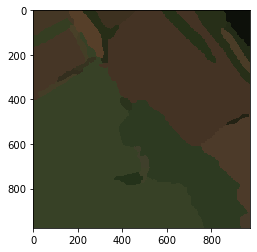

In [140]:
cut= cut_helper.horizontal_cut_from_altitude(1000)
simplified = cut.reconstruct_leaf_data(tree, mean_color)
plt.imshow(simplified)

In [95]:
def neighbor(i,j,label):
    # left
    left = label[i-1,j]
    # above
    above = label[i,j-1]
    neighbor_array = [left,above]
    return neighbor_array

In [124]:
new = 0
m,n=bin_outl.shape[:2]
label = np.ones([m,n])

# link array
link = []
id_ = 0 # link index also present object number

# first pass
for row in range(m):
    for column in range(n):
        # no object
#         print(image[row,column] == 0)
        if bin_outl[row,column] == [0] :
            label[row, column] = 0
#             l.write(str(int(label[row,column])))
        # object
        else : # check neighbor label
            current_neighbor = neighbor(row,column,label)

            # current is new label
            if current_neighbor == [0,0]:
                new= new + 1
                label[row, column] = new
#                 l.write(str(int(label[row, column])))

            # neighbor got label
            else :
                # only one neighbor labeling => choose the large one (the only label)
                if np.min(current_neighbor) == 0 or current_neighbor[0] == current_neighbor[1] :
                    label[row,column] = np.max(current_neighbor)
#                     l.write(str(int(label[row, column])))

                else:
                    label[row,column] = np.min(current_neighbor)
#                     l.write(str(int(label[row, column])))
                    if id == 0:
                        link.append(current_neighbor)
                        id = id +1
                        #print(link)
                    else:
                        check = 0
                        for k in range(id_) :
                            # 交集
                            tmp = set(link[k]).intersection(set(current_neighbor))
                            if len(tmp) != 0 :
                                link[k] = set(link[k]).union(current_neighbor)
                                np.array(link)
                                check = check + 1
                                #print(link)
                        if check == 0:
                            id_ = id_ +1
                            np.array(link)
                            link.append(set(current_neighbor))
#     l.write('\n')


# second pass
for row in range(m):
    for column in range(n):
        for x in range(id_):
            if (label[row, column] in link[x]) and label[row, column] !=0 :
                label[row, column] = min(link[x])
# update file
# for row in range(m):
#     for column in range(n):
#         R.write(str(int(label[row, column])))
#     R.write('\n')

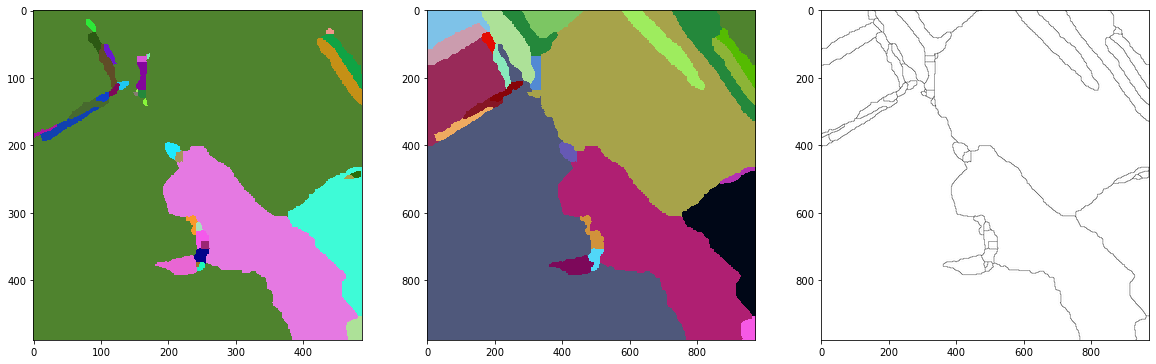

In [155]:
cmap = matplotlib.colors.ListedColormap ( np.random.rand ( 256,3))

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(label[::2,::2], cmap=cmap)
plt.subplot(1,3,2)
plt.imshow(simplified[:,:,0], cmap=cmap)
plt.subplot(1,3,3)
plt.imshow(bin_outl,cmap='gray',interpolation='lanczos')

In [213]:
def get_neighbor(i,j,M,N):
    nb=[]
    for_i=[]  
    ind=j+i*N
#     print(ind)
    
    if i>0:for_i.append(-N)
    if i<(M-1):for_i.append(N)
    if j>0:for_i.append(-1)
    if j<(N-1):for_i.append(1)
    for_i=[ind+i for i in for_i] 
#     print(for_i)
    out_neig=[]
    for ind_ in for_i:
        i_rec=ind_//N
        j_rec=ind_%N
        out_neig.append([i_rec,j_rec])    
    
    return out_neig


def FloodFill(X, Y,M,N,Label, outim):
    I=outim
    I[X,Y]= Label
    
    for x,y in get_neighbor(X, Y,M,N):    
        if I[x,y] == 1:
            FloodFill(x, y, Label)

def CCL(Image):    
    Label= 1
    M,N=Image.shape[:2]
    outim=np.zeros((M,N))
    for X in range(M):
        for Y in range(N):
            if Image[X, Y] == 1:
                Label+= 1
                FloodFill(X, Y,M,N,Label, outim)
    return outim

In [214]:
ii=CCL(bin_outl)

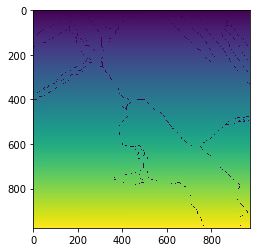

In [216]:
plt.imshow(ii)

In [4]:
import os

In [ ]:
os.listdir

In [4]:
import os
from PIL import Image
import numpy as np
base_path='/media/sgr/storage/trash/clipped_sent'
fl_names=[fl for fl in os.listdir(base_path) if fl[-3:]=='tif']
fl_batch_names=sorted(list(set([nm.split('_',maxsplit=1)[0] for nm in fl_names])))
data=[]
for batch in fl_batch_names:    
    data.append(np.array([np.asarray(Image.open(os.path.join(base_path,fl_nm))) for fl_nm in fl_names if batch in fl_nm]))
    



In [6]:
countours=[]
for batch in data:
    countours.append(np.array([get_contour(predicter.resolve_imar(im)) for im in batch]))
        


/home/sgr/Загрузки/cob_tf/python/COBresolve.py:100: RuntimeWarning: invalid value encountered in true_divide
  O=(np.sum(ab*w1w2,axis=0)/np.sum((ab>0)*w1w2,axis=0)*((ind1*ind2==0)+(abs(ind1-ind2)==1))-1)*np.pi/numClusters


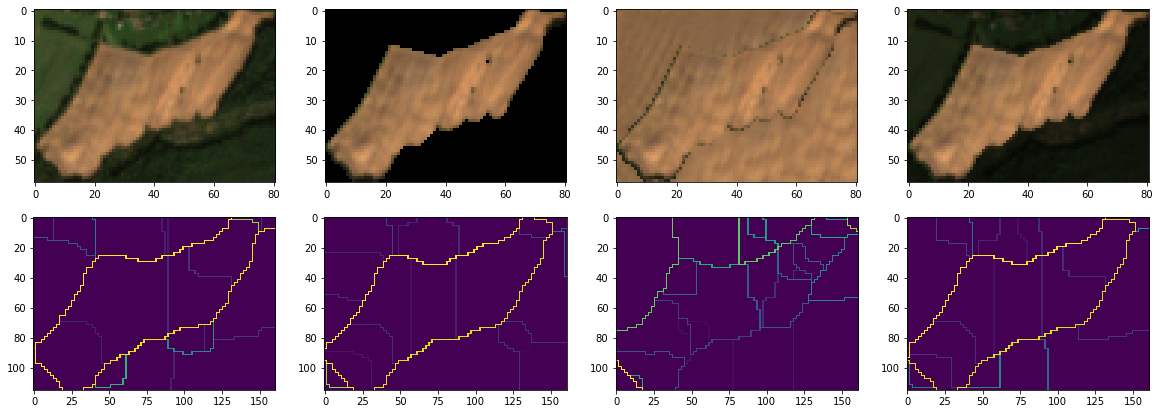

In [124]:
nm=3
plt.figure(figsize=(20,7))
plt.subplot(2,4,5)
plt.imshow(countours[nm][0])
plt.subplot(2,4,1)
plt.imshow(data[nm][0])

# plt.subplot(2,3,5)
# plt.imshow(np.max(np.array([countours[nm][1],countours[nm][2]]),axis=0))

plt.subplot(2,4,6)
plt.imshow(countours[nm][1])
plt.subplot(2,4,2)
plt.imshow(data[nm][1])

plt.subplot(2,4,7)
plt.imshow(countours[nm][2])
plt.subplot(2,4,3)
plt.imshow(data[nm][2])


shaded=np.array([data[nm][0],data[nm][1]]).mean(axis=0).astype(int)
shaded_cnt=get_contour(predicter.resolve_imar(shaded))
plt.subplot(2,4,4)
plt.imshow(shaded)
plt.subplot(2,4,8)
plt.imshow(shaded_cnt)





In [307]:
nm=4

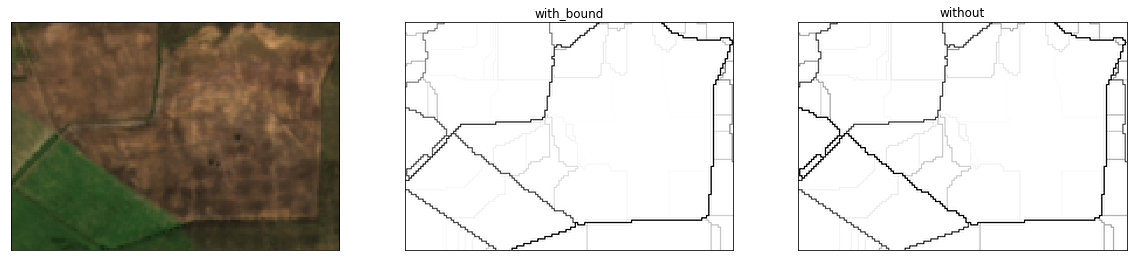

In [308]:
# get hierarchical contours


shaded=np.array([data[nm][0],data[nm][2]]).mean(axis=0).astype(int)

image=shaded
# image=data[nm][0]

output=predicter.resolve_imar(image)
# output=predicter.resolve_imar(image)

hh=np.copy(data[nm][1])
hh[hh>0]=255

from scipy import signal

Ix=signal.correlate2d(hh[:,:,0],[[1,2,1],[0,0,0],[-1,-2,-1]], mode='same',boundary='symm')
Iy=signal.correlate2d(hh[:,:,0],[[1,0,-1],[2,0,-2],[1,0,-1]], mode='same',boundary='symm')

G = np.hypot(Ix, Iy)
# G = signal.correlate2d(G,[[0.04]*5]*5, mode='same')

G = G / G.max()
theta = np.arctan2(Iy, Ix)


size = image.shape[:2]

# gradient_coarse = output[1]
# gradient_fine = output[0]
# gradient_orientation = output[2]

gradient_coarse = np.array([output[1],G]).max(axis=0)
gradient_fine = np.array([output[0],G]).max(axis=0)
gradient_orientation = output[2]



graph = hg.get_4_adjacency_graph(size)
edge_weights_fine = hg.weight_graph(graph, gradient_fine, hg.WeightFunction.mean)
edge_weights_coarse = hg.weight_graph(graph, gradient_coarse, hg.WeightFunction.mean)
edge_weights_hig = hg.weight_graph(graph, G, hg.WeightFunction.mean)



# special handling for angles to wrap around the trigonometric cycle...
edge_orientations_source = hg.weight_graph(graph, gradient_orientation, hg.WeightFunction.source) 
edge_orientations_target = hg.weight_graph(graph, gradient_orientation, hg.WeightFunction.target) 
edge_orientations = hg.mean_angle_mod_pi(edge_orientations_source, edge_orientations_target)

combined_hierarchy, altitudes_combined = hg.multiscale_mean_pb_hierarchy(graph, edge_weights_fine, others_edge_weights=(edge_weights_coarse,edge_weights_hig), edge_orientations=edge_orientations)
outlines=hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(combined_hierarchy, altitudes_combined))



combined_hierarchy1, altitudes_combined1 = hg.multiscale_mean_pb_hierarchy(graph, edge_weights_fine, others_edge_weights=(edge_weights_coarse,), edge_orientations=edge_orientations)
outlines1=hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(combined_hierarchy1, altitudes_combined1))



intr=['none', 'nearest', 'bilinear', 'bicubic',
    'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser',
    'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc',
    'lanczos']

plt.figure(figsize=(20,20))
# plt.figure(figsize=(10,10))

intrr=16
for num, (im, name) in enumerate(zip([image, outlines,outlines1], ['image', 'with_bound', 'without'])):
    plt.subplot(1,3,num+1)
    if len(im.shape)==2:
        plt.imshow(1-im,cmap='gray', interpolation=intr[intrr])
        plt.title(name)
    else:
        plt.imshow(im)
    plt.xticks([])
    plt.yticks([])

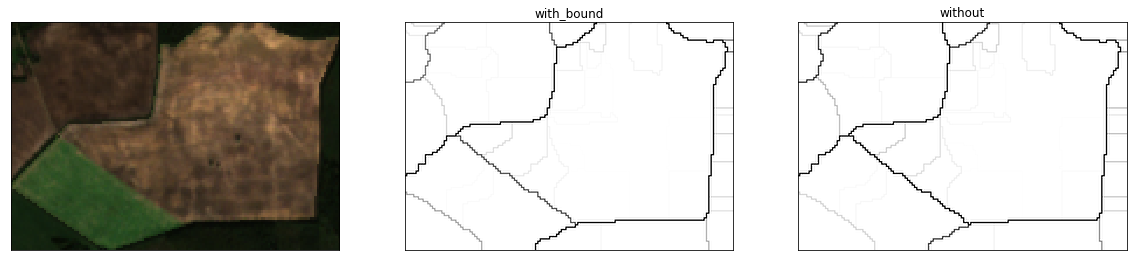

In [309]:
shaded=np.array([data[nm][0],data[nm][1]]).mean(axis=0).astype(int)

image=shaded
# image=data[nm][0]

output=predicter.resolve_imar(image)
# output=predicter.resolve_imar(shaded)

hh=np.copy(data[nm][1])
hh[hh>0]=255

from scipy import signal

Ix=signal.correlate2d(hh[:,:,0],[[1,2,1],[0,0,0],[-1,-2,-1]], mode='same',boundary='symm')
Iy=signal.correlate2d(hh[:,:,0],[[1,0,-1],[2,0,-2],[1,0,-1]], mode='same',boundary='symm')
G = np.hypot(Ix, Iy)
G = G / G.max()
theta = np.arctan2(Iy, Ix)


size = image.shape[:2]

gradient_coarse = output[1]
gradient_fine = output[0]
gradient_orientation = output[2]

graph = hg.get_4_adjacency_graph(size)
edge_weights_fine = hg.weight_graph(graph, gradient_fine, hg.WeightFunction.mean)
edge_weights_coarse = hg.weight_graph(graph, gradient_coarse, hg.WeightFunction.mean)
edge_weights_hig = hg.weight_graph(graph, G, hg.WeightFunction.mean)



# special handling for angles to wrap around the trigonometric cycle...
edge_orientations_source = hg.weight_graph(graph, gradient_orientation, hg.WeightFunction.source) 
edge_orientations_target = hg.weight_graph(graph, gradient_orientation, hg.WeightFunction.target) 
edge_orientations = hg.mean_angle_mod_pi(edge_orientations_source, edge_orientations_target)

combined_hierarchy, altitudes_combined = hg.multiscale_mean_pb_hierarchy(graph, edge_weights_fine, others_edge_weights=(edge_weights_coarse,edge_weights_hig), edge_orientations=edge_orientations)
outlines=hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(combined_hierarchy, altitudes_combined))



combined_hierarchy1, altitudes_combined1 = hg.multiscale_mean_pb_hierarchy(graph, edge_weights_fine, others_edge_weights=(edge_weights_coarse,), edge_orientations=edge_orientations)
outlines1=hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(combined_hierarchy1, altitudes_combined1))



intr=['none', 'nearest', 'bilinear', 'bicubic',
    'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser',
    'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc',
    'lanczos']

plt.figure(figsize=(20,20))
# plt.figure(figsize=(10,10))

intrr=16
for num, (im, name) in enumerate(zip([image, outlines,outlines1], ['image', 'with_bound', 'without'])):
    plt.subplot(1,3,num+1)
    if len(im.shape)==2:
        plt.imshow(1-im,cmap='gray', interpolation=intr[intrr])
        plt.title(name)
    else:
        plt.imshow(im)
    plt.xticks([])
    plt.yticks([])

In [3]:
from scipy.spatial.distance import cdist
import numpy as np
from matplotlib import pyplot as plt

In [1]:
from matplotlib import pyplot as plt
jsonstr="""{"type": "FeatureCollection",
            "name": "trash_",
            "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::3352" } },
            "features": [{ "type": "Feature", 
                                "properties": { "gridcode": 8 },
                            "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 2310288.8002, 6121052.6629 ], 
                                                                                        [ 2310493.194699999876, 6121010.797599999234 ], 
                                                                                        [ 2310721.3392, 6121044.137499999255 ], 
                                                                                        [ 2311079.0541, 6120899.039799999446 ], 
                                                                                        [ 2311243.683, 6120955.387499999255 ], 
                                                                                        [ 2311198.643899999559, 6120779.65509999916 ], 
                                                                                        [ 2311309.6791, 6120735.866 ], 
                                                                                        [ 2311307.60879999958, 6120634.352299999446 ], 
                                                                                        [ 2311188.058, 6120576.344499999657 ], 
                                                                                        [ 2311034.893899999559, 6120483.4734 ], 
                                                                                        [ 2311018.253299999982, 6120466.149199999869 ], 
                                                                                        [ 2310948.058, 6120475.9539 ], 
                                                                                        [ 2310924.8744, 6120594.7137 ], 
                                                                                        [ 2310848.058, 6120695.9539 ], 
                                                                                        [ 2310828.448599999771, 6120796.344499999657 ], 
                                                                                        [ 2310728.058, 6120815.9539 ], 
                                                                                        [ 2310663.9369, 6120837.897199999541 ], 
                                                                                        [ 2310423.253299999982, 6120832.985099999234 ], 
                                                                                        [ 2310368.448599999771, 6120775.9539 ], 
                                                                                        [ 2310330.440799999982, 6120756.344499999657 ], 
                                                                                        [ 2310308.448599999771, 6120936.344499999657 ], 
                                                                                        [ 2310286.847099999897, 6120957.1062 ], 
                                                                                        [ 2310288.8002, 6121052.6629 ] ] ] ] } }]}"""

In [2]:
class preproc_image:
    def __init__(self, image, geojson):
        self.image=image
        self.geojson=geojson
        self.flag=0
    def get_coord_from_geojson(self):
        import json
        jsn=json.loads(self.geojson)
        self.coords=jsn['features'][0]['geometry']['coordinates'][0][0]
        self.flag=1
    def get_mask_from_path(self):
        from matplotlib import path as path
        import numpy as np
        
        if self.flag<1: 
            print('First calculate coords from json')
            return
        
        X,Y=list(zip(*self.coords))
        x_min,y_min=int(min(X)-1),int(min(Y)-1)
        X_, Y_=[x-x_min for x in X], [y-y_min for y in Y]
        x_max,y_max=int(max(X_)+2), int(max(Y_)+2)

        poly=list(zip(X_, Y_))
        pgn=path.Path(poly)
        all_points=[(x,y) for y in reversed(range(y_max)) for x in range(x_max) ]
        self.masked=np.array(pgn.contains_points(all_points)).reshape(y_max,x_max)
        self.flag=2
    def get_distanse_raster_from_bin_mask(self):
        from scipy import ndimage
        import numpy as np
        
        if self.flag<2: 
            print('First calculate mask from coords')
            return
        
        msk=np.copy(self.masked)

        while msk.max()>0:
            bn=msk<1
            dil=ndimage.binary_dilation(bn)
            msk=msk-dil*1
        mnm=np.min(msk)
        msk-=mnm
        msk*=-1

        msk1=np.copy(self.masked)==0
        while msk1.min()>np.min(msk):
            bn=msk1<1
            dil=ndimage.binary_dilation(bn)
            msk1=msk1-dil*1
        msk1-=mnm

        msk1[msk1==0]=msk[msk1==0]
        self.distance=msk1

In [3]:
vv=preproc_image('trash', jsonstr)
vv.get_coord_from_geojson()
vv.get_mask_from_path()
vv.get_distanse_raster_from_bin_mask()

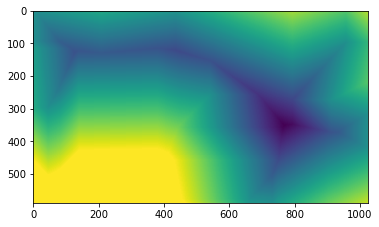

In [4]:
plt.imshow(vv.distance)

In [674]:
def get_coord_from_geojson(json_str):
    import json
    jsn=json.loads(jsonstr)
    return jj['features'][0]['geometry']['coordinates'][0][0]

def get_mask_from_path(coords, xy_origin=None):
    from matplotlib import path as path
    import numpy as np
    X,Y=list(zip(*coords))
    
    if xy_origin:
        x_min,y_min=xy_origin
    else:    
        x_min,y_min=int(min(X)-1),int(min(Y)-1)
    X_, Y_=[x-x_min for x in X], [y-y_min for y in Y]
    x_max,y_max=int(max(X_)+2), int(max(Y_)+2)

    poly=list(zip(X_, Y_))
    pgn=path.Path(poly)
    all_points=[(x,y) for y in reversed(range(y_max)) for x in range(x_max) ]
    masked=np.array(pgn.contains_points(all_points)).reshape(y_max,x_max)
    return masked 

def get_distanse_raster_from_bin_mask(masked):
    from scipy import ndimage
    import numpy as np 
    msk=np.copy(masked)

    while msk.max()>0:
        bn=msk<1
        dil=ndimage.binary_dilation(bn)
        msk=msk-dil*1
    mnm=np.min(msk)
    msk-=mnm
    msk*=-1

    msk1=np.copy(masked)==0
    while msk1.min()>np.min(msk):
        bn=msk1<1
        dil=ndimage.binary_dilation(bn)
        msk1=msk1-dil*1
    msk1-=mnm

    msk1[msk1==0]=msk[msk1==0]
    return msk1

In [ ]:
coord1=get_coord_from_geojson(jsonstr)
mask0=get_mask_from_path(coord1)
dist=get_distanse_raster_from_bin_mask(mask0)

plt.imshow(get_distanse_raster_from_bin_mask(masked))